# Data Mining Project

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

account = pd.read_csv('../data/account.csv',delimiter=';')
card_dev = pd.read_csv('../data/card_dev.csv',delimiter=';')
client = pd.read_csv('../data/client.csv',delimiter=';')
disp = pd.read_csv('../data/disp.csv',delimiter=';')
district = pd.read_csv('../data/district.csv',delimiter=';')
loan_dev = pd.read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = pd.read_csv('../data/trans_dev.csv',delimiter=';', dtype={'bank':'str'})

## Business Understanding

The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

## Data Understanding

### Build Dataset

In [31]:
def parse_date(d):
  year = int(str(d)[0:2])
  month = int(str(d)[2:4])
  day = int(str(d)[4:6])
  return { 'year': year, 'month': month, 'day': day }

In [32]:
def parse_gender(row, birth_date):
  female = birth_date['month'] >= 50

  if female:
    row['gender'] = 'female' 
    birth_date['month'] -= 50
  else:
    row['gender'] = 'male' 

In [33]:
def calculate_age_loan(row):
  date_loan = row['date_loan']
  birth_number = row['birth_number']

  birth_date = parse_date(birth_number)

  parse_gender(row, birth_date)
  
  if (date_loan is None):
    date_loan = parse_date(row['date_loan'])
    date_loan = date_loan['year'] - birth_date['year'] - ((date_loan['month'], date_loan['day']) < (birth_date['month'], birth_date['day']))
  
  row['age_loan'] = date_loan
    
  return row

In [51]:
# join account, loan, disposition and client
df = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='left')
df = df.merge(disp, on='account_id', suffixes=('','_disp'), how='left')
df = df.merge(client, on='client_id',suffixes=('','_client'), how='left')

df.drop(columns='district_id', axis=1, inplace=True)

# create age_at_loan and gender column
df = df.apply(lambda row: calculate_age_loan(row), axis=1)

# join demograph
district.rename(columns={'code ':'code'}, inplace=True)
df = df.merge(district, left_on='district_id_client', right_on='code', how='left')

# join creditcard
df = df.merge(card_dev, on='disp_id', suffixes=('', '_card'), how='left')

# join transactions
df = df.merge(trans_dev, on='account_id', suffixes=('', '_transaction'), how='left')

In [35]:
df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,issued,trans_id,date_transaction,type_transaction,operation,amount_transaction,balance,k_symbol,bank,account
0,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,NaN,171812.0,930101.0,credit,credit in cash,900.0,900.0,NaN,NaN,NaN
1,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,NaN,171813.0,930111.0,credit,collection from another bank,6207.0,7107.0,old-age pension,YZ,30300313.0
2,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,NaN,3549613.0,930131.0,credit,NaN,20.1,7127.1,interest credited,NaN,NaN
3,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,NaN,171814.0,930211.0,credit,collection from another bank,6207.0,13334.1,old-age pension,YZ,30300313.0
4,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,NaN,3549614.0,930228.0,credit,NaN,29.6,13363.7,interest credited,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475993,3958,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,4775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475994,777,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475995,1573,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,1906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475996,3276,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,3965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Analysis

- número de disponentes vs status 
    - quantas pessoas podem depositar naquela conta / contas quantas aquela pessoa tem ??
- amount da loan vs status 
    - isto tipo não sei se faz super sentido era mais para perceber se o risco aumenta quanto maior for a loan ou se não podems concluir isso
    
- crime rate vs status
- taxa de desemprego vs status
- salário médio da região
- ... outros dados demográficos vs status ??
- diferença salário médio e dinheiro da loan pago a cada mês vs status
    - se o que a pessoa paga em cada mês é quase a totalidade do seu salário, é mais provável que não possa pagar a dada altura
- duration vs status
- género vs status
- frequência com que é utilizada a conta vs status
    - ver pelo número de transactions, no fundo é se é cliente ativo ou não
- percentagem de depósitos/débitos vs status 
    - my thought process foi que se eu só uso a conta para debitar dinheiro secalhar tou a gastar mais do que o ganho kk
- quantas loans tem 'ativas' 
    - ver interseção data de aceitação + duração
- ...


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475998 entries, 0 to 475997
Data columns (total 44 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   account_id                                         475998 non-null  int64  
 1   frequency                                          475998 non-null  object 
 2   date                                               475998 non-null  int64  
 3   loan_id                                            30373 non-null   float64
 4   date_loan                                          30373 non-null   float64
 5   amount                                             30373 non-null   float64
 6   duration                                           30373 non-null   float64
 7   payments                                           30373 non-null   float64
 8   status                                             30373 non-null   float6

Text(0.5, 1.0, 'Status count for bank loans')

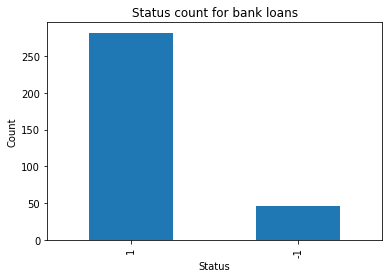

In [37]:
loan_dev['status'].value_counts().plot.bar()
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status count for bank loans')

<AxesSubplot:title={'center':'amount'}, xlabel='status'>

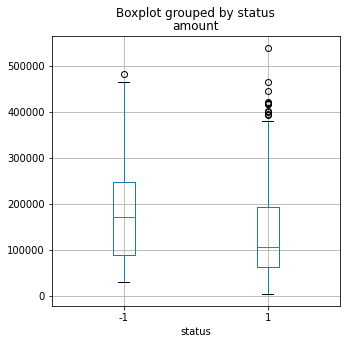

In [38]:
loan_dev.boxplot(column='amount', by='status', figsize=(5,5))

<AxesSubplot:title={'center':'payments'}, xlabel='status'>

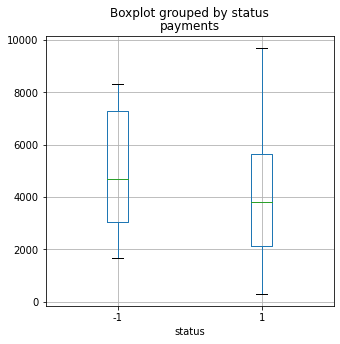

In [39]:
loan_dev.boxplot(column='payments', by='status', figsize=(5,5))

<AxesSubplot:title={'center':'duration'}, xlabel='status'>

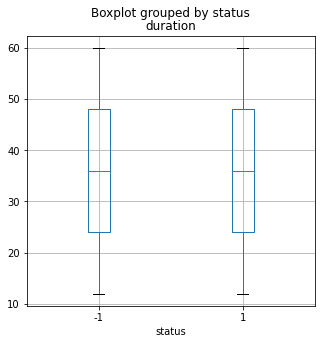

In [40]:
loan_dev.boxplot(column='duration', by='status', figsize=(5,5))


Since the boxes are not totally aligned, there might be a relation between the loan amount and the successfulness of a loan. The higher the amount, the most likely it is to fail. The differences in the graphics aren't, however, significant and our conclusions are enforced by logic.

<AxesSubplot:title={'center':'age_loan'}, xlabel='status'>

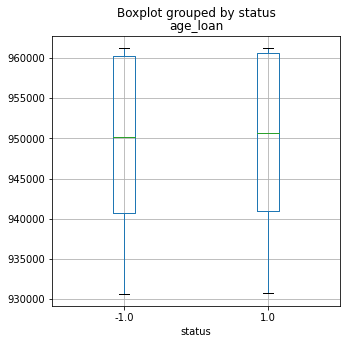

In [41]:
df.boxplot(column='age_loan', by='status', figsize=(5,5))


In [52]:
disp_count = df.groupby(['account_id'])['disp_id'].nunique()
disp_count

account_id
1        1
2        2
3        2
4        1
5        1
        ..
11333    1
11349    2
11359    1
11362    1
11382    1
Name: disp_id, Length: 4500, dtype: int64

In [53]:
df = df.merge(disp_count, on='account_id', suffixes=('', '_count'), how='left')


In [54]:
df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,trans_id,date_transaction,type_transaction,operation,amount_transaction,balance,k_symbol,bank,account,disp_id_count
0,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171812.0,930101.0,credit,credit in cash,900.0,900.0,NaN,NaN,NaN,2
1,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171813.0,930111.0,credit,collection from another bank,6207.0,7107.0,old-age pension,YZ,30300313.0,2
2,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,3549613.0,930131.0,credit,NaN,20.1,7127.1,interest credited,NaN,NaN,2
3,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171814.0,930211.0,credit,collection from another bank,6207.0,13334.1,old-age pension,YZ,30300313.0,2
4,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,3549614.0,930228.0,credit,NaN,29.6,13363.7,interest credited,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475993,3958,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,4775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
475994,777,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
475995,1573,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,1906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
475996,3276,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,3965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


<AxesSubplot:title={'center':'disp_id_count'}, xlabel='status'>

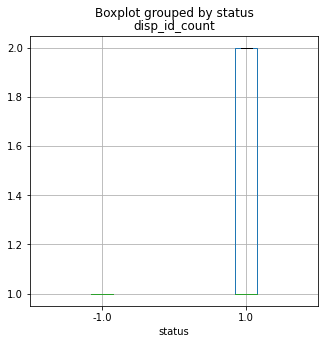

In [55]:
df.boxplot(column='disp_id_count', by='status', figsize=(5,5))

In [65]:
df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,trans_id,date_transaction,type_transaction,operation,amount_transaction,balance,k_symbol,bank,account,disp_id_count
0,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171812.0,930101.0,credit,credit in cash,900.0,900.0,NaN,NaN,NaN,2
1,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171813.0,930111.0,credit,collection from another bank,6207.0,7107.0,old-age pension,YZ,30300313.0,2
2,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,3549613.0,930131.0,credit,NaN,20.1,7127.1,interest credited,NaN,NaN,2
3,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,171814.0,930211.0,credit,collection from another bank,6207.0,13334.1,old-age pension,YZ,30300313.0,2
4,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,3549614.0,930228.0,credit,NaN,29.6,13363.7,interest credited,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475993,3958,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,4775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
475994,777,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
475995,1573,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,1906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
475996,3276,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,3965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [76]:
count = df.groupby(by = ['disp_id_count', 'status']).count()
count

account_id  frequency   date  loan_id  date_loan  \
disp_id_count status                                                     
1             -1.0          2970       2970   2970     2970       2970   
               1.0         15645      15645  15645    15645      15645   
2              1.0         11758      11758  11758    11758      11758   

                      amount  duration  payments  disp_id  client_id  ...  \
disp_id_count status                                                  ...   
1             -1.0      2970      2970      2970     2970       2970  ...   
               1.0     15645     15645     15645    15645      15645  ...   
2              1.0     11758     11758     11758    11758      11758  ...   

                      issued  trans_id  date_transaction  type_transaction  \
disp_id_count status                                                         
1             -1.0         0      2970              2970              2970   
               1.0       745     15645             15645             15645   
2              1.0       293     11758             11758             11758   

                      operation  amount_transaction  balance  k_symbol  bank  \
disp_id_count status                                                           
1             -1.0         2366                2970     2970      1166   211   
               1.0        12945               15645    15645      6465  2865   
2              1.0         9704               11758    11758      4820  2192   

                      account  
disp_id_count status           
1             -1.0        573  
               1.0       4523  
2              1.0       3488  

[3 rows x 43 columns]

In [67]:
X_axis = np.arange(len(df['disp_id_count']))
X_axis


array([     0,      1,      2, ..., 475995, 475996, 475997])

In [ ]:
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')

plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'average salary '}, xlabel='status'>

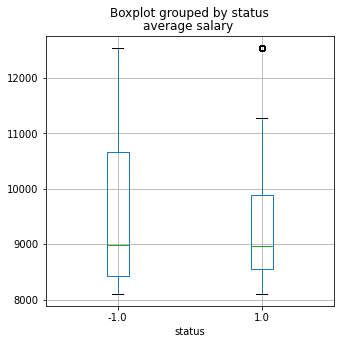

In [63]:
df.boxplot(column='average salary ', by='status', figsize=(5,5))

## Data Preparation

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,date_transaction,type_transaction,operation,amount_transaction,balance,k_symbol,bank,account,disp_id_count,disp_id_aaa
0,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,930101.0,credit,credit in cash,900.0,900.0,NaN,NaN,NaN,2,2
1,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,930111.0,credit,collection from another bank,6207.0,7107.0,old-age pension,YZ,30300313.0,2,2
2,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,930131.0,credit,NaN,20.1,7127.1,interest credited,NaN,NaN,2,2
3,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,930211.0,credit,collection from another bank,6207.0,13334.1,old-age pension,YZ,30300313.0,2,2
4,576,monthly issuance,930101,NaN,NaN,NaN,NaN,NaN,NaN,692,...,930228.0,credit,NaN,29.6,13363.7,interest credited,NaN,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475993,3958,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,4775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
475994,777,monthly issuance,971228,NaN,NaN,NaN,NaN,NaN,NaN,929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
475995,1573,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,1906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
475996,3276,monthly issuance,971229,NaN,NaN,NaN,NaN,NaN,NaN,3965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2


## Model